In [58]:
from graphmodels.database import select_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

from graphmodels.data_utils import data_dict_from_df_tables, get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic

plt.style.use('ggplot')

def prepare_water_model_data():

    # Select dataset
    df_tables = ["aquastat", 'worldbank', 'evapotranspiration', 'cropcalendar', 'efficientwater', 'sarahcrops']

    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    # Preprocess some datasets
    df_dictionnary['cropcalendar'] = df_dictionnary['cropcalendar'].drop(columns=['Year'])
    df_dictionnary['aquastat'] = df_dictionnary['aquastat'][~df_dictionnary['aquastat'].Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
    df_dictionnary['sarahcrops'] = df_dictionnary['sarahcrops'][~df_dictionnary['sarahcrops'].Variable.isin(['ICA', 'CI'])]


    # Convert to model readable datadict
    data_dict = data_dict_from_df_tables([df for _, df in df_dictionnary.items()])

    ISOs = df_dictionnary['aquastat'].ISO.unique()
    
    # Impute missing values
    def preprocess_dict_item(key, value):
        mux = pd.MultiIndex.from_product([ISOs, range(2000, 2020)],
                                     names=['ISO', 'Year'])

        if key in ['ICA', 'Kc']:
            return value
        else:
            return (
                  value.reindex(mux)
                      .groupby(level='ISO')
                      .fillna(method='ffill')
                      .groupby(level='ISO')
                      .fillna(method='bfill')
                      .fillna(0) )


    data_dict = {k: preprocess_dict_item(k, v).sort_index() for k, v in data_dict.items()}
    

    return data_dict

data_dict = prepare_water_model_data()

In [59]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3 TO CHECK
mm_to_m = 1e-2  # 1e-3 
mmyear_to_m3year = 1e-2 #  from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit':'1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
}

EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))
EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))

In [60]:
X, y = get_X_y_from_data(EW_model, data_dict)
res = EW_model.run(X)
print(score_model(EW_model, X, y))

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
IWR
IWW
AWU
MWU
TWW
TFA
EW1
EW2
         r2  correlation          rmse Variable
0  0.673832     0.959427     49.031668      IWR
1 -0.137856     0.345620    194.301120      IWW
2  0.625183     0.930965    193.370224      AWU
3  0.868318     0.937490      0.964228      MWU
4  0.710473     0.939077    209.338453      TWW
5  0.967648     0.988029  15564.492575      TFA
6  0.739366     0.860135    942.307315      EW1
7 -0.254559     0.155474  35751.635878      EW2


<AxesSubplot:xlabel='Year', ylabel='EW1'>

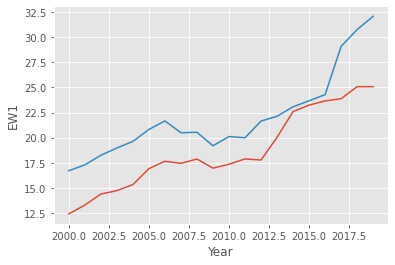

In [61]:
sns.lineplot(data=y['EW1'].loc['HUN'])
sns.lineplot(data=res['EW1'].loc['HUN'])

<AxesSubplot:xlabel='Year', ylabel='EW2'>

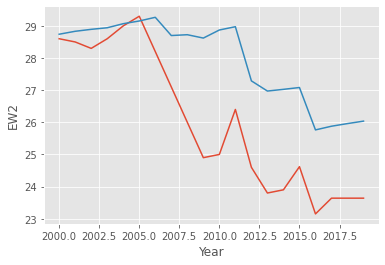

In [62]:
sns.lineplot(data=y['EW2'].loc['FRA'])
sns.lineplot(data=res['EW2'].loc['FRA'])

In [163]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


def reindex_series_non_itemized(df, min_year=2000, max_year=2050):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(min_year, max_year+1)], names=['ISO', 'Year'])
    return df.reindex(multi_index)


def reindex_series_itemized(df, min_year=2000, max_year=2050):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(min_year, max_year+1), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_percent_target_projection(series, percent_target=0, baseline_year=2018, target_year=2050):
    series = series.copy()
    series = reindex_series_non_itemized(series, max_year=target_year)
    series.loc[:, target_year, :] = percent_target * series.loc[:, baseline_year, :].values
    return series.interpolate()


def apply_itemized_percent_target_projection(series, percent_target=0, baseline_year=2018, target_year=2050):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = reindex_series_itemized(series, max_year=target_year)
    series.loc[:, target_year, :] = percent_target * series.loc[:, baseline_year, :].values


def apply_annual_rate_projection(series, rate=1, baseline_year=2018, target_year=2050):
    series = series.copy()
    series = reindex_series_non_itemized(series, max_year=target_year)

    year = series.loc[:, baseline_year:].index.get_level_values(level='Year').values

    series.loc[:, baseline_year:] = series.loc[:, baseline_year].values * rate ** (year - baseline_year)

    return series


def apply_constant_projection(series, constant=0, baseline_year=2018, target_year=2050):
    series = series.copy()
    series = reindex_series_non_itemized(series, max_year=target_year)
    series.loc[:, baseline_year:] = constant

    return series


def apply_itemized_ffill_projection(series, target_year=2050):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = reindex_series_itemized(series, max_year=target_year)

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')


def apply_ffill_projection(series, target_year=2050):
    series = series.copy()
    series = reindex_series_non_itemized(series, max_year=target_year)

    return series.groupby(['ISO']).fillna(method='ffill')



def apply_Holt_projection(series, baseline_year=2018, target_year=2050, smoothing_level=0.3):
    '''Improve choice of smoothing methods'''
    series = series.copy()
    series = reindex_series_non_itemized(series, max_year=target_year)

    for ISO in series.index.get_level_values('ISO').unique():
        fit = Holt(series.loc[ISO, :baseline_year].values).fit(smoothing_level=smoothing_level)
        series.loc[ISO, baseline_year:target_year+1] = fit.forecast(target_year - baseline_year + 1)

    return series

def run_projection(projection_dict, data_dict):
    data_dict = data_dict.copy()

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict


In [164]:
def run_Water_projection(data_dict):

    projection_dict = {
        'IGVA': lambda x: apply_Holt_projection(x),
        'SGVA': lambda x: apply_Holt_projection(x),
        'AGVA': lambda x: apply_Holt_projection(x),
        'GDPC': lambda x: apply_Holt_projection(x),
        'Pop': lambda x: apply_Holt_projection(x),
        'AIR': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'CL': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'Arice': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'ETo': lambda x: apply_ffill_projection(x),
        'ETa': lambda x: apply_ffill_projection(x),
        'IRWR': lambda x: apply_ffill_projection(x),
        'ERWR': lambda x: apply_ffill_projection(x),
        'IWU': lambda x: apply_ffill_projection(x),
        'DW': lambda x: apply_ffill_projection(x),
        'TW': lambda x: apply_ffill_projection(x),
        'EFR': lambda x: apply_ffill_projection(x),
     }

    return run_projection(projection_dict, data_dict)


def run_BE2_scenario(data_dict, WP_rate=1.05, WRR_rate=1.01):

    data_dict = data_dict.copy()

    projection_dict = {
        'WP': lambda x: apply_annual_rate_projection(x, WP_rate),
        'WRR': lambda x: apply_annual_rate_projection(x, WRR_rate),
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = EW_model.run(data_dict)

    return results

In [172]:
ISO_data_dict = {k: v.loc['FRA', :] for k, v in data_dict.items()}

proj_ISO_data_dict = run_Water_projection(ISO_data_dict)

s_1 = run_BE2_scenario(proj_ISO_data_dict, WP_rate=1.05, WRR_rate=1.01)
s_2 = run_BE2_scenario(proj_ISO_data_dict, WP_rate=1.5, WRR_rate=1.01)
s_3 = run_BE2_scenario(proj_ISO_data_dict, WP_rate=0.9, WRR_rate=1.01)

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


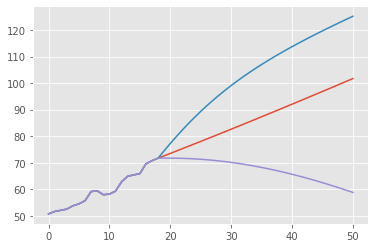

In [174]:
plt.plot(s_1['EW1'].values)
plt.plot(s_2['EW1'].values)
plt.plot(s_3['EW1'].values)


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def apply_scenario_WP(WP, rate):
    WP = WP.copy()
    for i in range(2020, 2051):
        WP.loc[:, i] = (WP.loc[:, 2019] * rate ** (i - 2019)).values
    return WP


def apply_projection_GVA(GVA):
    GVA = GVA.copy()
    for ISO in GVA.index.get_level_values('ISO').unique():
        fit = Holt(GVA.loc[ISO, 2000:2020].values).fit(smoothing_level=0.3)
        GVA.loc[ISO, 2020:2050] = fit.forecast(31)
       
    return GVA


def apply_projection_AIR(AIR, rate=1.05):
    AIR = AIR.copy()
    for i in range(2020, 2051):
        AIR.loc[:, i] = (AIR.loc[:, 2019] * rate ** (i - 2019)).values
    return AIR

def apply_scenario_WRR(WR, rate=0.9):
    WR = WR.copy()
    for i in range(2020, 2051):
        WR.loc[:, i] = (WR.loc[:, 2019] * rate ** (i - 2019)).values
    return WR

In [ ]:
#AGVA_proj = apply_projection_GVA(data_dict_expanded['AGVA'])
#IGVA_proj = apply_projection_GVA(data_dict_expanded['IGVA'])
#SGVA_proj = apply_projection_GVA(data_dict_expanded['SGVA'])
# plt.plot(IGVA_proj.loc['FRA'])bb

In [ ]:
data_dict_expanded['IGVA'] = apply_projection_GVA(data_dict_expanded['IGVA'])
data_dict_expanded['AGVA'] = apply_projection_GVA(data_dict_expanded['AGVA'])
data_dict_expanded['SGVA'] = apply_projection_GVA(data_dict_expanded['SGVA'])
data_dict_expanded['GDPC'] = apply_projection_GVA(data_dict_expanded['GDPC'])
data_dict_expanded['AIR'] = apply_projection_AIR(data_dict_expanded['AIR'], rate=1.01)
data_dict_expanded['CL'] = apply_projection_AIR(data_dict_expanded['CL'], rate=1.01)

In [ ]:
def scenario_BAU(data_dict_expanded=data_dict_expanded):

    data_dict_expanded = data_dict_expanded.copy()
    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    res = EW_model.run(X)

    return res

def scenario_1(data_dict_expanded=data_dict_expanded):
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.1)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

def scenario_2(data_dict_expanded=data_dict_expanded):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.05)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)


def scenario(data_dict_expanded=data_dict_expanded, WP_rate=1, WRR_rate=1):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=WP_rate)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=WRR_rate)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

In [ ]:
res_1 = scenario()
res_2 = scenario(WP_rate=1.05, WRR_rate=1)
res_3 = scenario(WP_rate=1.1, WRR_rate=0.999)

In [ ]:
ISO = 'FRA'

def plot_var_scenarios(var, ISO=ISO):
    sns.lineplot(data=res_1[var].loc[ISO], label='BAU')
    sns.lineplot(data=res_2[var].loc[ISO], label='scenarios 1')
    sns.lineplot(data=res_3[var].loc[ISO], label='scenarios 2')
    plt.show()

def plot_context(ISO=ISO):
    sns.lineplot(data=res_1['IGVA'].loc[ISO], label='IGVA')
    sns.lineplot(data=res_1['SGVA'].loc[ISO], label='SGVA')
    sns.lineplot(data=res_1['AGVA'].loc[ISO], label='AGVA')
    plt.show()
    sns.lineplot(data=res_1['GDPC'].loc[ISO], label='GDPC')
    plt.show()


plot_var_scenarios('EW1')
plot_var_scenarios('EW2')
plot_var_scenarios('TWW')
plot_var_scenarios('WP')
plot_var_scenarios('WRR')

plot_context()


# First cleanup for demo

In [ ]:
import pandas as pd
MWU_df = pd.read_csv('outputs/MWU_df.csv')

In [ ]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}

EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))

In [ ]:
def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict

In [ ]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(1980, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index, method='ffill')

def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(1980, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def expand_data_dict(data_dict):
    data_dict_expanded = {}

    for key, item in data_dict.items():
        if key not in ['Kc', 'ICA']:
            data_dict_expanded[key] = expand_series_non_itemized(item)

    data_dict_expanded['Kc'] = data_dict['Kc']
    data_dict_expanded['ICA'] = data_dict['Kc']

    return data_dict_expanded


def apply_scenario_WP(WP, rate):
    WP = WP.copy()
    for i in range(2020, 2051):
        WP.loc[:, i] = (WP.loc[:, 2019] * rate ** (i - 2019)).values
    return WP


def apply_projection_GVA(GVA):
    GVA = GVA.copy()
    for ISO in GVA.index.get_level_values('ISO').unique():
        fit = Holt(GVA.loc[ISO, 2000:2020].values).fit(smoothing_level=0.3)
        GVA.loc[ISO, 2020:2050] = fit.forecast(31)
       
    return GVA


def apply_projection_AIR(AIR, rate=1.05):
    AIR = AIR.copy()
    for i in range(2020, 2051):
        AIR.loc[:, i] = (AIR.loc[:, 2019] * rate ** (i - 2019)).values
    return AIR

def apply_scenario_WRR(WR, rate=0.9):
    WR = WR.copy()
    for i in range(2020, 2051):
        WR.loc[:, i] = (WR.loc[:, 2019] * rate ** (i - 2019)).values
    return WR

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


def apply_projection(data_dict_expanded):
    data_dict_expanded['IGVA'] = apply_projection_GVA(data_dict_expanded['IGVA'])
    data_dict_expanded['AGVA'] = apply_projection_GVA(data_dict_expanded['AGVA'])
    data_dict_expanded['SGVA'] = apply_projection_GVA(data_dict_expanded['SGVA'])
    data_dict_expanded['GDPC'] = apply_projection_GVA(data_dict_expanded['GDPC'])
    data_dict_expanded['AIR'] = apply_projection_AIR(data_dict_expanded['AIR'], rate=1.01)
    data_dict_expanded['CL'] = apply_projection_AIR(data_dict_expanded['CL'], rate=1.01)

    return data_dict_expanded

In [ ]:
data_dict = df_to_data_dict(MWU_df, ['ICA', 'Kc'])
data_dict_expanded = expand_data_dict(data_dict)
data_dict_expanded = apply_projection(data_dict_expanded)

In [ ]:
data_dict_expanded = {key.split('.')[0]: pd.read_csv(f"outputs/projection_data/{key.split('.')[0]}.csv", index_col=['ISO', 'Year']).iloc[:, 0] for key in os.listdir('outputs/projection_data')}

data_dict_expanded['ICA'] = pd.read_csv('outputs/projection_data/ICA.csv', index_col=['ISO', 'Year', 'Item']).iloc[:, 0]
data_dict_expanded['Kc'] = pd.read_csv('outputs/projection_data/Kc.csv', index_col=['ISO', 'Year', 'Item']).iloc[:, 0]

In [ ]:
def scenario_BAU(data_dict_expanded=data_dict_expanded):

    data_dict_expanded = data_dict_expanded.copy()
    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    res = EW_model.run(X)

    return res

def scenario_1(data_dict_expanded=data_dict_expanded):
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.1)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

def scenario_2(data_dict_expanded=data_dict_expanded):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.05)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)


def scenario(data_dict_expanded=data_dict_expanded, WP_rate=1, WRR_rate=1):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=WP_rate)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=WRR_rate)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

In [ ]:
res_1 = scenario()
res_2 = scenario(WP_rate=1, WRR_rate=1.1)
res_3 = scenario(WP_rate=1, WRR_rate=0.9)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

ISO = 'FRA'

def plot_var_scenarios(var, ISO=ISO):
    sns.lineplot(data=res_1[var].loc[ISO], label='BAU')
    sns.lineplot(data=res_2[var].loc[ISO], label='scenarios 1')
    sns.lineplot(data=res_3[var].loc[ISO], label='scenarios 2')
    plt.show()

def plot_context(ISO=ISO):
    sns.lineplot(data=res_1['IGVA'].loc[ISO], label='IGVA')
    sns.lineplot(data=res_1['SGVA'].loc[ISO], label='SGVA')
    sns.lineplot(data=res_1['AGVA'].loc[ISO], label='AGVA')
    plt.show()
    sns.lineplot(data=res_1['GDPC'].loc[ISO], label='GDPC')
    plt.show()


plot_var_scenarios('EW1')
plot_var_scenarios('EW2')
plot_var_scenarios('TWW')
plot_var_scenarios('WP')
plot_var_scenarios('WRR')

plot_context()


In [ ]:
scenarios_results = {}
scenarios_results['BAU'] = res_1
scenarios_results['scenario_1'] = res_2
scenarios_results['scenario_2'] = res_3

In [ ]:
import plotly.express as px

In [ ]:
def make_var_df(var, scenarios_results=scenarios_results):
    dfs = []
    for scenario, res_dict in scenarios_results.items():
        dfs.append(res_dict[var].to_frame(name=var).assign(scenario=scenario))
    return pd.concat(dfs, axis=0)


In [ ]:
test_df = make_var_df('EW1').reset_index()
px.line(test_df.query("ISO == 'FRA'"), x='Year', y='EW1', color='scenario')

In [ ]:
test_df = make_var_df('WRR').reset_index()
px.line(test_df.query("ISO == 'FRA'"), x='Year', y='WRR', color='scenario')

In [ ]:
A = {'A': 2, 'B': 3}

In [ ]:
A.update({"C": 18})

In [ ]:
A